In [273]:
from pymc import DiscreteUniform, Exponential, deterministic, Poisson, Uniform
import numpy as np
import pandas as pd
import pymc
import seaborn as sns
import scipy, scipy.stats
import pylab
from matplotlib import pyplot as plt
sns.set(color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [103]:
df = pd.read_csv('data/BRCA-filtered.txt.gz', sep = '\t', index_col = 0)

In [104]:
dft = df.transpose()

In [105]:
dft.describe()

Hybridization REF,ZNF114|163071,ZNF205|7755,ZNF267|10308,ZNF273|10793,ZNF282|8427,ZNF320|162967,ZNF468|90333,ZNF485|220992,ZNF525|170958,ZNF643|65243,ZNF695|57116,ZNF707|286075,ZNF714|148206,ZNF789|285989
count,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000
mean,12.576513,347.575895,398.256743,187.515418,766.155671,554.047879,525.213938,94.063056,356.378570,54.168991,64.737524,306.359949,207.186751,83.554836
std,20.742740,229.445553,162.465444,94.716513,297.252856,226.898840,265.294146,52.517578,189.589890,50.221778,92.532610,201.956632,144.442256,55.042386
min,0.000000,9.898200,66.974900,13.296500,203.954500,27.126700,0.000000,8.248700,16.313300,2.773200,0.000000,19.690000,5.563800,13.478500
25%,2.991875,202.597050,291.780850,126.669375,567.045500,416.147625,354.286325,58.756425,232.752975,31.028025,13.299850,175.862175,113.151375,51.724725
50%,6.079650,290.524800,374.052700,169.914400,713.686650,533.681900,475.463150,83.982100,316.397200,45.689550,31.317150,252.475900,173.293800,71.558200
75%,13.739800,423.733950,472.502525,230.077300,909.611125,659.080350,643.390675,116.818375,436.268800,65.076475,75.633725,374.347625,261.369675,101.026800
max,223.798800,2199.999400,1396.205800,1195.750700,2461.977200,2460.255000,2473.269800,636.937500,1874.049000,1265.807200,1028.171700,1735.496700,1140.401600,804.298100


In [124]:
sample_row = 'ZNF114|163071'
sample_row_2 = 'ZNF205|7755'

In [125]:
# 1 - tumor
# 11 - healthy
healthy = dft.iloc[dft.index.str.contains("-11A-")]
tumor = dft.iloc[dft.index.str.contains("-01A-")]

<function matplotlib.pyplot.legend>

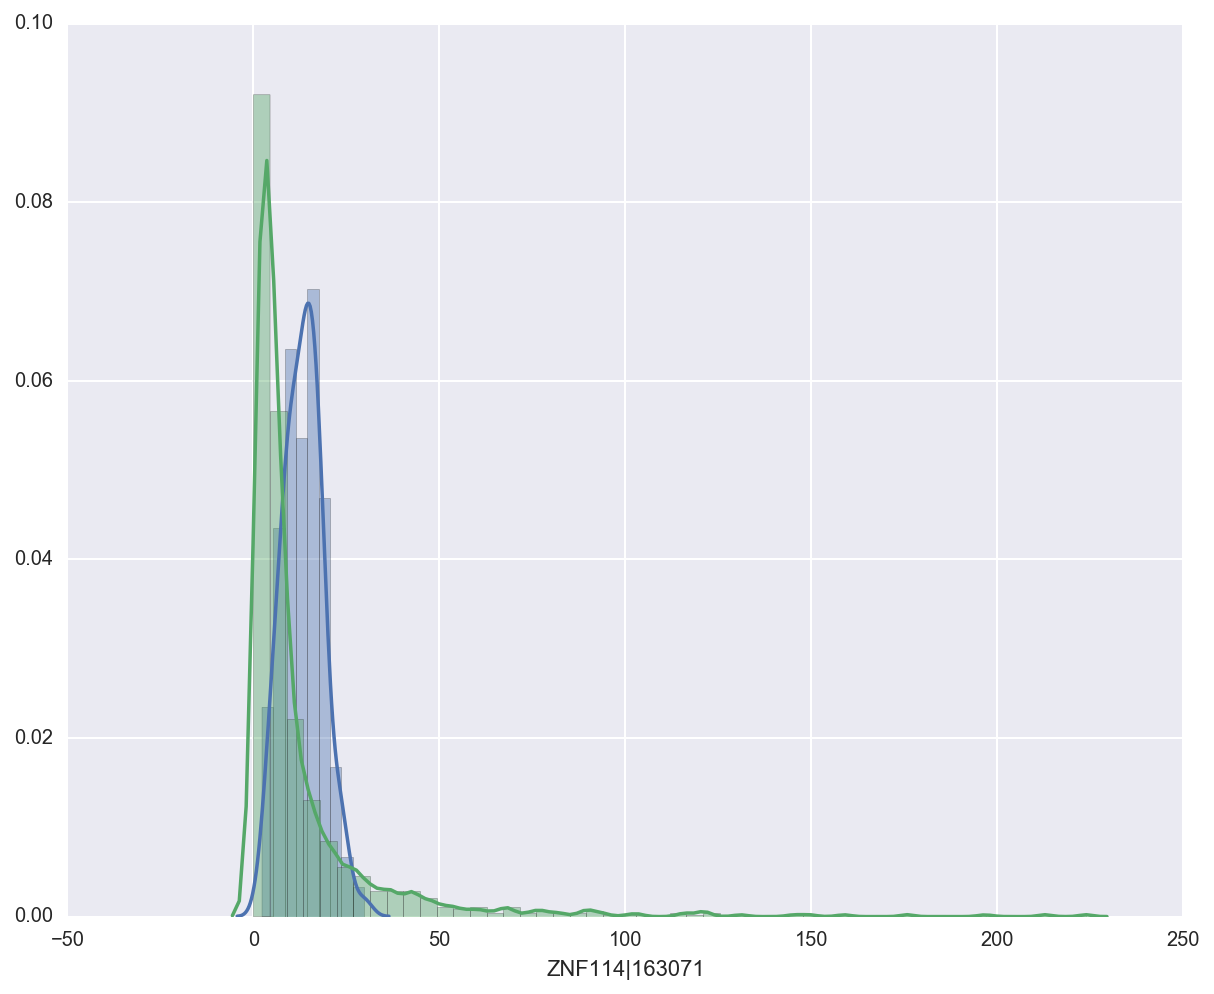

In [157]:
plt.figure(figsize=(10, 8))
sns.distplot(healthy[sample_row], label = 'healthy')
sns.distplot(tumor[sample_row], label = 'tumor')
plt.legend

In [312]:
p_A = pymc.Uniform('p_A', 0, 1)

p_XXX = pymc.Uniform('p_XXX', 1, 20)

obs = pymc.NegativeBinomial('tumor', p_XXX, p_A, value=tumor[sample_row], observed=True)

In [313]:
model = pymc.Model([p_A, p_XXX, obs])
mcmc = pymc.MCMC(model)

mcmc.sample(1000000, 500000)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 428.3 sec

0.68839927070259133

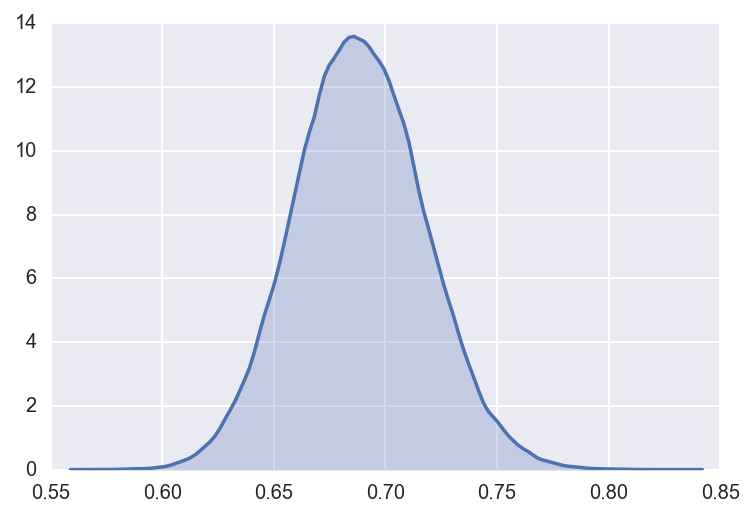

In [314]:
a = mcmc.trace('p_A')[:]
sns.kdeplot(a, shade = True)
np.mean(a)

12.129716422251507

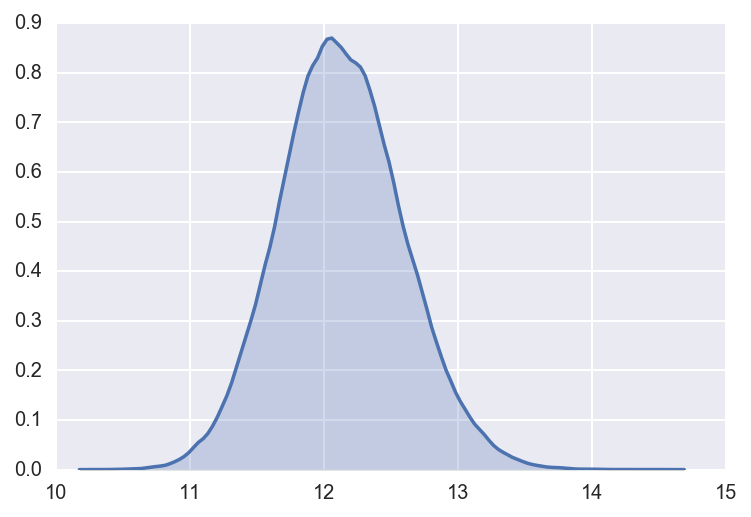

In [315]:
xxx = mcmc.trace('p_XXX')[:]
sns.kdeplot(xxx, shade = True)
np.mean(xxx)

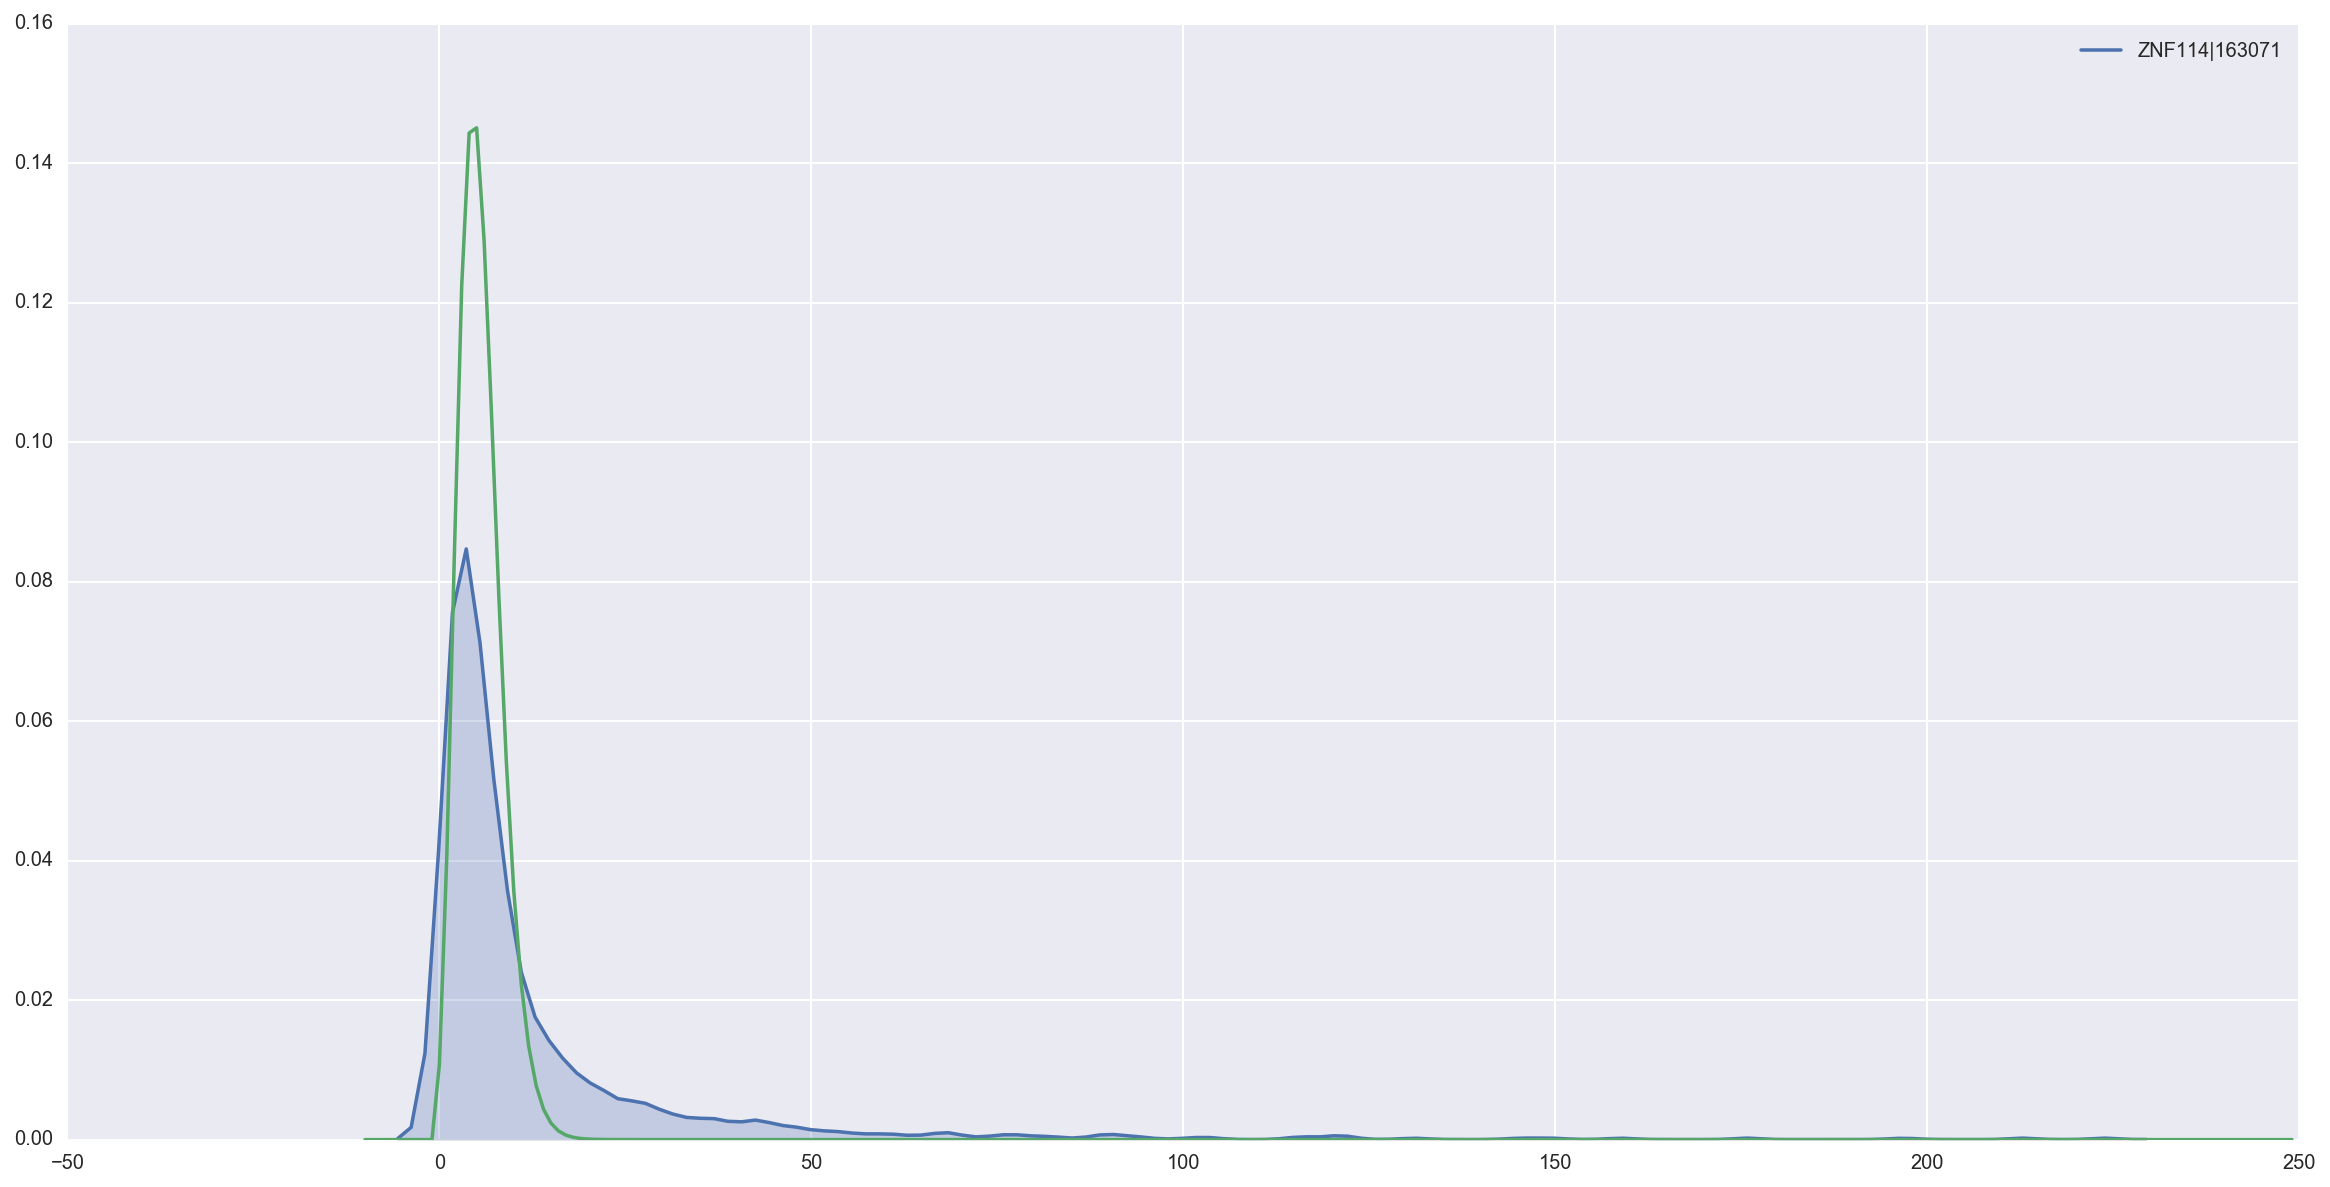

In [317]:
plt.figure(figsize=(20, 10))
sns.kdeplot(tumor[sample_row], shade = True)

x = np.arange(-10, 250, 1)
pmf = scipy.stats.nbinom.pmf(x, np.mean(xxx), np.mean(a))
pylab.plot(x,pmf)

Plotting p_XXX
Plotting p_A


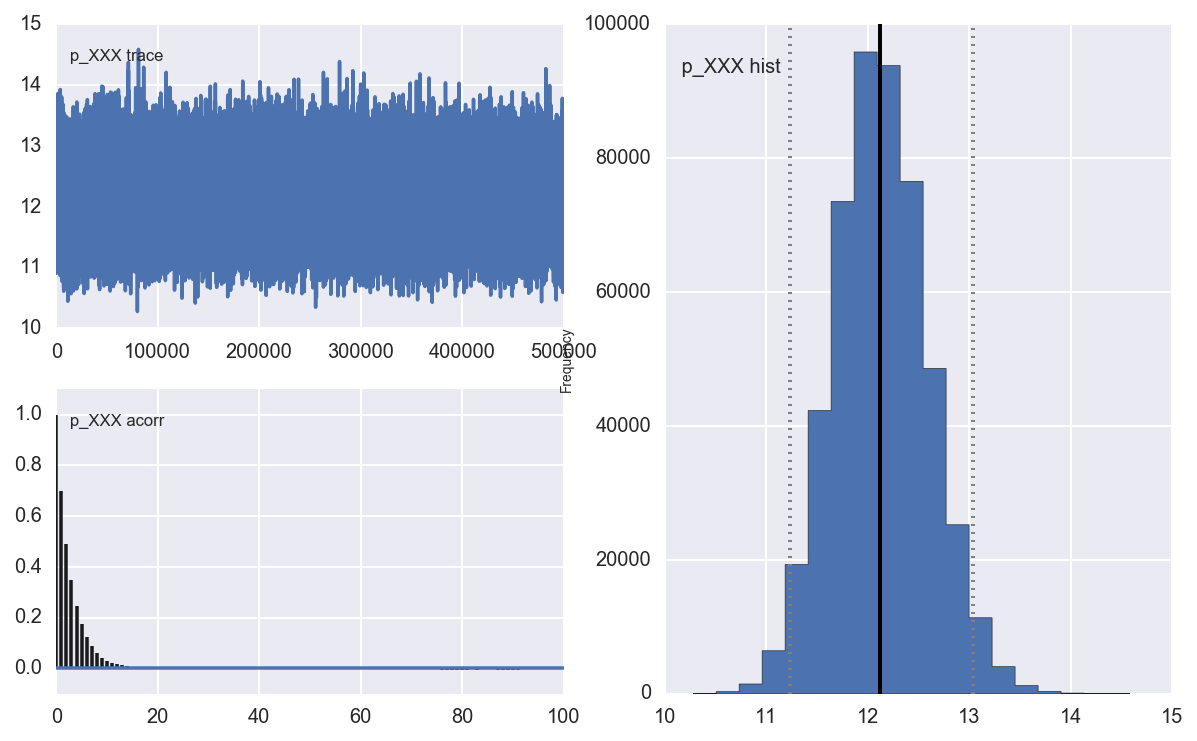

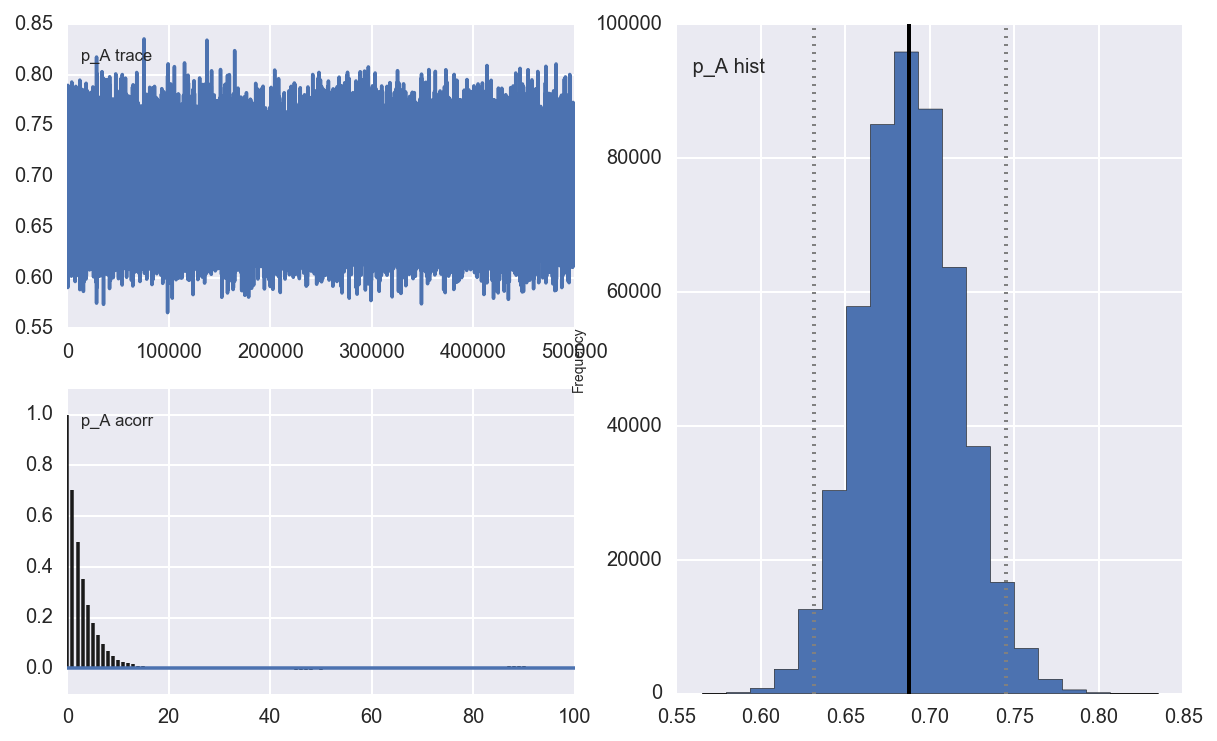

In [319]:
from pymc.Matplot import plot as mcplot
mcplot(mcmc.trace('p_XXX'), common_scale=False)
mcplot(mcmc.trace('p_A'), common_scale=False)